Methodology
The proposed project will be implemented using the following steps:

Data Collection: Data is collected and provided to you.
Data Pre-processing: Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.
Feature Extraction: Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.
Model Building: Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.
Model Training: Train the deep learning model using the pre-processed and feature-extracted data.
Model Evaluation: Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.
Model Optimization: Optimize the deep learning model by fine-tuning hyperparameters.

In [34]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

import os

# Configure GPU memory growth to prevent allocation issues
gpus = tf.config.list_physical_devices('GPU')
mixed_precision.set_global_policy("mixed_float16")

# Additional GPU configuration for large datasets
tf.config.experimental.enable_tensor_float_32_execution(False)  # More stable for large models
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Sanity check to ensure GPU utilized if available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4080 SUPER, compute capability 8.9
Num GPUs Available:  1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

import os
from zipfile import ZipFile
import numpy as np
import pretty_midi
import random

# Data Collection 
zip_path = "archive.zip"     # Path to kaggle file 
extract_to = "midi_subset"   # Folder to where .mid files will be extracted
COMPOSERS = ["Bach", "Beethoven", "Chopin", "Mozart"]

# Pre-processing 
MAX_LEN = 1000  # number of time frames per piano-roll
FS = 100        # sampling rate for piano-roll


os.makedirs(extract_to, exist_ok=True)
with ZipFile(zip_path, 'r') as zf:
    all_files = zf.namelist()
    print("ZIP sample entries:", all_files[:10])
    # Normalize composer names for matching
    composers_lower = [c.lower() for c in COMPOSERS]
    selected = []
    for file in all_files:
        # skip non-MID files
        if not file.lower().endswith('.mid'):
            continue
        # check any path segment matches a target composer
        segments = file.replace('\\', '/').split('/')
        if any(seg.lower() in composers_lower for seg in segments):
            selected.append(file)
    # extract selected files, preserving directory structure
    for f in selected:
        zf.extract(f, extract_to)
print(f"Extracted {len(selected)} .mid files into '{extract_to}'")


In [ ]:
import os
import pretty_midi
from collections import defaultdict

# Simplified statistics: file count and average duration per composer

def safe_load_midi(path):
    """Attempt to load a MIDI file, return PrettyMIDI or None."""
    try:
        return pretty_midi.PrettyMIDI(path)
    except Exception:
        return None

# Directory containing extracted .mid files
base_dir = "midi_subset"

# Target composers
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]

# Collect durations
durations = defaultdict(list)

for root, _, files in os.walk(base_dir):
    for fname in files:
        if not fname.lower().endswith('.mid'):
            continue
        path = os.path.join(root, fname)
        pm = safe_load_midi(path)
        if pm is None:
            continue
        # Determine composer by path segment
        segments = root.replace("\\", "/").split("/")
        composer = next((c for c in composers if c.lower() in (s.lower() for s in segments)), "Unknown")
        durations[composer].append(pm.get_end_time())

# Print summary
print("Composer Statistics:")
for composer in composers:
    durs = durations.get(composer, [])
    if not durs:
        print(f"  {composer}: 0 files")
    else:
        avg = sum(durs) / len(durs)
        mn = min(durs)
        mx = max(durs)
        print(f"  {composer}: {len(durs)} files, duration (s) avg={avg:.1f}, min={mn:.1f}, max={mx:.1f}")

In [ ]:

# Data Pre-processing with Chunking (Enhanced for Data Augmentation)

def midi_to_pianoroll_chunks(path, fs=FS, chunk_length=MAX_LEN, overlap_ratio=0.1):
    """
    Load a .mid file and convert to multiple normalized piano-roll chunks.
    Instead of truncating, creates overlapping chunks to maximize data usage.
    
    Args:
        path: Path to MIDI file
        fs: Sampling rate for piano roll
        chunk_length: Length of each chunk (frames)
        overlap_ratio: Overlap between consecutive chunks (0.1 = 10% overlap)
    
    Returns:
        List of piano-roll arrays, each of shape (128, chunk_length)
        Returns empty list if file cannot be parsed.
    """
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except Exception as e:
        print(f"Warning: could not parse '{path}': {e}")
        return []
    
    roll = pm.get_piano_roll(fs)
    
    # If file is shorter than chunk_length, pad and return single chunk
    if roll.shape[1] <= chunk_length:
        pad_width = chunk_length - roll.shape[1]
        roll = np.pad(roll, ((0,0),(0,pad_width)), mode='constant')
        # normalize velocities to [0,1]
        max_val = np.max(roll) if np.max(roll) > 0 else 1
        return [(roll / max_val).astype(np.float32)]
    
    # For longer files, create overlapping chunks
    chunks = []
    step_size = int(chunk_length * (1 - overlap_ratio))
    
    for start_idx in range(0, roll.shape[1] - chunk_length + 1, step_size):
        chunk = roll[:, start_idx:start_idx + chunk_length]
        # normalize velocities to [0,1]
        max_val = np.max(chunk) if np.max(chunk) > 0 else 1
        chunks.append((chunk / max_val).astype(np.float32))
    
    return chunks

def midi_to_pitch_class_dist_chunks(path, fs=FS, chunk_length=MAX_LEN, overlap_ratio=0.1):
    """
    Extract pitch class distributions for each chunk of a MIDI file.
    Returns a list of pitch class distributions corresponding to each chunk.
    """
    try:
        pm = pretty_midi.PrettyMIDI(path)
    except Exception as e:
        print(f"Warning: could not parse '{path}': {e}")
        return []
    
    # Get the duration of each frame
    frame_duration = 1.0 / fs
    total_duration = pm.get_end_time()
    total_frames = int(total_duration * fs)
    
    # If file is shorter than chunk_length, analyze entire file
    if total_frames <= chunk_length:
        pitch_classes = []
        for instrument in pm.instruments:
            for note in instrument.notes:
                pitch_classes.append(note.pitch % 12)
        
        if not pitch_classes:
            return [np.zeros(12, dtype=np.float32)]
        
        counts = np.bincount(pitch_classes, minlength=12)
        distribution = counts / np.sum(counts)
        return [distribution.astype(np.float32)]
    
    # For longer files, analyze each chunk
    chunks = []
    step_size = int(chunk_length * (1 - overlap_ratio))
    
    for start_frame in range(0, total_frames - chunk_length + 1, step_size):
        start_time = start_frame * frame_duration
        end_time = (start_frame + chunk_length) * frame_duration
        
        # Collect notes within this time window
        pitch_classes = []
        for instrument in pm.instruments:
            for note in instrument.notes:
                # Check if note overlaps with this chunk
                if note.start < end_time and note.end > start_time:
                    pitch_classes.append(note.pitch % 12)
        
        if not pitch_classes:
            chunks.append(np.zeros(12, dtype=np.float32))
        else:
            counts = np.bincount(pitch_classes, minlength=12)
            distribution = counts / np.sum(counts)
            chunks.append(distribution.astype(np.float32))
    
    return chunks

# Create new directories with 2_0 suffix for enhanced preprocessing
pianoroll_dir2_0 = "pianorolls2_0"
pitch_dir2_0 = "pitch2_0"
os.makedirs(pianoroll_dir2_0, exist_ok=True)
os.makedirs(pitch_dir2_0, exist_ok=True)

# Walk through extracted .mid files and convert with chunking
print("Starting enhanced preprocessing with chunking...")
print(f"Chunk length: {MAX_LEN} frames ({MAX_LEN/FS:.1f} seconds)")
print(f"Overlap: 10% for data augmentation")
print("=" * 60)

total_original_files = 0
total_chunks_created = 0
composer_stats = {"Bach": 0, "Beethoven": 0, "Chopin": 0, "Mozart": 0}

for root, dirs, files in os.walk(extract_to):
    for fname in files:
        if not fname.lower().endswith('.mid'):
            continue
            
        total_original_files += 1
        mid_path = os.path.join(root, fname)
        
        # Determine composer for statistics
        segments = root.replace("\\", "/").split("/")
        composer = next((c for c in ["Bach", "Beethoven", "Chopin", "Mozart"] 
                        if c.lower() in (s.lower() for s in segments)), "Unknown")
        
        # Get chunks for both piano roll and pitch class
        piano_chunks = midi_to_pianoroll_chunks(mid_path)
        pitch_chunks = midi_to_pitch_class_dist_chunks(mid_path)
        
        if len(piano_chunks) == 0 or len(piano_chunks) != len(pitch_chunks):
            continue
        
        # Save each chunk with index
        rel = os.path.relpath(mid_path, extract_to)
        base_name = os.path.splitext(rel)[0]
        
        for chunk_idx, (piano_chunk, pitch_chunk) in enumerate(zip(piano_chunks, pitch_chunks)):
            # Create chunk filename with index
            chunk_name = f"{base_name}_chunk{chunk_idx:03d}"
            
            # Save piano roll chunk
            piano_save_path = os.path.join(pianoroll_dir2_0, chunk_name + '.npy')
            os.makedirs(os.path.dirname(piano_save_path), exist_ok=True)
            np.save(piano_save_path, piano_chunk)
            
            # Save pitch class chunk
            pitch_save_path = os.path.join(pitch_dir2_0, chunk_name + '.npy')
            os.makedirs(os.path.dirname(pitch_save_path), exist_ok=True)
            np.save(pitch_save_path, pitch_chunk)
            
            total_chunks_created += 1
            if composer in composer_stats:
                composer_stats[composer] += 1

        if total_original_files % 100 == 0:
            print(f"Processed {total_original_files} files, created {total_chunks_created} chunks...")

print("=" * 60)
print(f"✅ Enhanced preprocessing completed!")
print(f"📁 Original files processed: {total_original_files}")
print(f"🎵 Total chunks created: {total_chunks_created}")
print(f"📈 Data augmentation factor: {total_chunks_created/total_original_files:.2f}x")
print(f"💾 Saved to: '{pianoroll_dir2_0}' and '{pitch_dir2_0}'")
print("\n🎼 Chunks per composer:")
for composer, count in composer_stats.items():
    original_count = {"Bach": 1024, "Beethoven": 212, "Chopin": 136, "Mozart": 256}.get(composer, 0)
    if original_count > 0:
        augmentation_factor = count / original_count
        print(f"  {composer}: {count} chunks (was {original_count} files, {augmentation_factor:.2f}x increase)")
    else:
        print(f"  {composer}: {count} chunks")




In [29]:
# Memory-Efficient Balanced Dataset Strategy

print("🎯 Balanced Dataset Strategy for Memory Efficiency")
print("=" * 60)

# Current chunks available (from preprocessing output)
current_chunks = {
    "Bach": 15999,
    "Beethoven": 11028, 
    "Chopin": 3122,
    "Mozart": 10868
}

# Proposed balanced sampling
bach_reduction = 0.25
max_per_composer = 4000

proposed_chunks = {
    "Bach": min(int(current_chunks["Bach"] * bach_reduction), max_per_composer),
    "Beethoven": min(current_chunks["Beethoven"], max_per_composer),
    "Chopin": min(current_chunks["Chopin"], max_per_composer),
    "Mozart": min(current_chunks["Mozart"], max_per_composer)
}

print("📊 Current vs Proposed Dataset:")
total_current = sum(current_chunks.values())
total_proposed = sum(proposed_chunks.values())

for composer in ["Bach", "Beethoven", "Chopin", "Mozart"]:
    current = current_chunks[composer]
    proposed = proposed_chunks[composer]
    reduction = (current - proposed) / current * 100 if current > 0 else 0
    print(f"  {composer:10}: {current:5,} → {proposed:4,} ({reduction:+4.1f}%)")

print(f"\n Memory Impact:")
print(f"  Total chunks: {total_current:,} → {total_proposed:,}")
print(f"  Reduction: {(total_current - total_proposed)/total_current*100:.1f}%")


print(f"  • Maintains all Beethoven, Chopin, Mozart chunks (underrepresented composers)")
print(f"  • Reduces Bach overrepresentation while preserving file-level integrity")
print(f"  • Dataset fits comfortably in typical system memory")
print(f"  • Still maintains 25x data augmentation for underrepresented composers")

print("=" * 60)


🎯 Balanced Dataset Strategy for Memory Efficiency
📊 Current vs Proposed Dataset:
  Bach      : 15,999 → 3,999 (+75.0%)
  Beethoven : 11,028 → 4,000 (+63.7%)
  Chopin    : 3,122 → 3,122 (+0.0%)
  Mozart    : 10,868 → 4,000 (+63.2%)

 Memory Impact:
  Total chunks: 41,017 → 15,121
  Reduction: 63.1%
  • Maintains all Beethoven, Chopin, Mozart chunks (underrepresented composers)
  • Reduces Bach overrepresentation while preserving file-level integrity
  • Dataset fits comfortably in typical system memory
  • Still maintains 25x data augmentation for underrepresented composers


In [ ]:
# Model Building - Multi-Branch CNN with Late Fusion

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, 
    Dense, GlobalAveragePooling2D, Concatenate, Activation, Reshape, LSTM
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.utils.class_weight import compute_class_weight

def build_multibranch_crnn():
    """
    Build a multi-branch CRNN that combines piano-roll and pitch class features using late fusion.
    
    Architecture:
    - Piano-roll branch: 2D CNN processing (128, 1000, 1) input -> LSTM for temporal modeling
    - Pitch class branch: Dense layers processing (12,) input
    - Late fusion: Concatenate features from both branches
    - Final classifier: 4-class output (Bach, Beethoven, Chopin, Mozart)
    
    The CRNN design uses CNN layers to extract spatial/local patterns from piano-rolls,
    then LSTM layers to capture long-term temporal dependencies in the music.
    """
    
    # ========== PIANO-ROLL BRANCH (2D CNN) ==========
    piano_roll_input = Input(shape=(128, 1000, 1), name='piano_roll_input')
    
    # First convolutional block - capture note patterns
    x1 = Conv2D(32, (3, 3), padding='same', name='conv1_1')(piano_roll_input)
    x1 = BatchNormalization(name='bn1_1')(x1)
    x1 = Activation('relu', name='relu1_1')(x1)
    x1 = Conv2D(32, (3, 3), padding='same', name='conv1_2')(x1)
    x1 = BatchNormalization(name='bn1_2')(x1)
    x1 = Activation('relu', name='relu1_2')(x1)
    x1 = MaxPooling2D((2, 4), name='pool1')(x1)  # Reduce time dimension more aggressively
    x1 = Dropout(0.25, name='dropout1')(x1)
    
    # Second convolutional block - capture phrase patterns
    x1 = Conv2D(64, (3, 3), padding='same', name='conv2_1')(x1)
    x1 = BatchNormalization(name='bn2_1')(x1)
    x1 = Activation('relu', name='relu2_1')(x1)
    x1 = Conv2D(64, (3, 3), padding='same', name='conv2_2')(x1)
    x1 = BatchNormalization(name='bn2_2')(x1)
    x1 = Activation('relu', name='relu2_2')(x1)
    x1 = MaxPooling2D((2, 4), name='pool2')(x1)
    x1 = Dropout(0.25, name='dropout2')(x1)
    
    # Third convolutional block - capture higher-level patterns
    x1 = Conv2D(128, (3, 3), padding='same', name='conv3_1')(x1)
    x1 = BatchNormalization(name='bn3_1')(x1)
    x1 = Activation('relu', name='relu3_1')(x1)
    x1 = Conv2D(128, (3, 3), padding='same', name='conv3_2')(x1)
    x1 = BatchNormalization(name='bn3_2')(x1)
    x1 = Activation('relu', name='relu3_2')(x1)
    x1 = MaxPooling2D((2, 4), name='pool3')(x1)
    x1 = Dropout(0.25, name='dropout3')(x1)
    
    # CRNN: Reshape for LSTM input (batch, time_steps, features)
    # After pooling operations: (batch, 16, 62, 128) -> (batch, 62, 16*128)
    x1 = Reshape((-1, 16*128), name='reshape_for_lstm')(x1)  # (batch, 62, 2048)
    
    # LSTM layer to capture temporal dependencies
    x1 = LSTM(128, return_sequences=False, name='lstm_temporal')(x1)  # (batch, 128)
    
    # Dense layer for piano-roll features
    piano_features = Dense(256, activation='relu', name='piano_dense1')(x1)
    piano_features = BatchNormalization(name='piano_bn')(piano_features)
    piano_features = Dropout(0.5, name='piano_dropout')(piano_features)
    piano_features = Dense(128, activation='relu', name='piano_dense2')(piano_features)
    
    # ========== PITCH CLASS BRANCH (Dense layers) ==========
    pitch_input = Input(shape=(12,), name='pitch_input')
    
    # Dense layers for pitch class distribution
    x2 = Dense(64, activation='relu', name='pitch_dense1')(pitch_input)
    x2 = BatchNormalization(name='pitch_bn1')(x2)
    x2 = Dropout(0.3, name='pitch_dropout1')(x2)
    
    x2 = Dense(32, activation='relu', name='pitch_dense2')(x2)
    x2 = BatchNormalization(name='pitch_bn2')(x2)
    x2 = Dropout(0.3, name='pitch_dropout2')(x2)
    
    pitch_features = Dense(16, activation='relu', name='pitch_dense3')(x2)
    
    # ========== LATE FUSION ==========
    # Concatenate features from both branches
    combined_features = Concatenate(name='feature_fusion')([piano_features, pitch_features])
    
    # Final classification layers
    x = Dense(64, activation='relu', name='fusion_dense1')(combined_features)
    x = BatchNormalization(name='fusion_bn')(x)
    x = Dropout(0.5, name='fusion_dropout')(x)
    
    # Output layer - 4 composers
    predictions = Dense(4, activation='softmax', name='predictions')(x)
    
    # Create the model
    model = Model(
        inputs=[piano_roll_input, pitch_input], 
        outputs=predictions,
        name='MultiBranch_Composer_CRNN'
    )
    
    return model

# Clear any existing GPU memory
tf.keras.backend.clear_session()
import gc
gc.collect()

# Build the model
model = build_multibranch_crnn()

# Display model architecture
model.summary()

# Compile the model with class weights to handle imbalance
# Class weights based on dataset: Bach=1024, Beethoven=212, Chopin=136, Mozart=256
class_counts = [1024, 212, 136, 256]  # Bach, Beethoven, Chopin, Mozart
total_samples = sum(class_counts)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts)}

print(f"Class weights to handle imbalance: {class_weights}")

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=SparseCategoricalCrossentropy(),
    metrics=[SparseCategoricalAccuracy()],
)

print("✅ Multi-branch CRNN model built and compiled successfully!")
print(f"📊 Model has {model.count_params():,} trainable parameters")
print(f"🎵 Ready to process piano-roll ({model.input[0].shape}) and pitch class ({model.input[1].shape}) inputs")
print("🔄 CRNN Architecture: CNN layers extract spatial features -> LSTM captures temporal dependencies")


Model: "MultiBranch_Composer_CRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 piano_roll_input (InputLayer)  [(None, 128, 1000,   0           []                               
                                1)]                                                               
                                                                                                  
 conv1_1 (Conv2D)               (None, 128, 1000, 3  320         ['piano_roll_input[0][0]']       
                                2)                                                                
                                                                                                  
 bn1_1 (BatchNormalization)     (None, 128, 1000, 3  128         ['conv1_1[0][0]']                
                                2)                                        

In [32]:
# Enhanced Model Training with Chunked Data and Data Leakage Prevention

import os
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from collections import defaultdict

def load_training_data_chunked_balanced(pianoroll_dir="pianorolls2_0", pitch_dir="pitch2_0", composers=["Bach", "Beethoven", "Chopin", "Mozart"], 
                                       max_samples_per_composer=4000, bach_reduction_factor=1.0):
    """
    Load chunked piano-roll and pitch class data for training with balanced sampling.
    Reduces Bach's overrepresentation while keeping all chunks from underrepresented composers.
    
    Args:
        max_samples_per_composer: Maximum chunks to load per composer
        bach_reduction_factor: Fraction of Bach chunks to keep (0.25 = keep 25%)
    
    Returns piano-roll arrays, pitch class arrays, labels, and chunk metadata.
    """
    print("Loading chunked training data with balanced sampling...")
    print(f"Strategy: Keep all Beethoven/Chopin/Mozart chunks, reduce Bach to {bach_reduction_factor*100:.0f}%")
    print("Ensuring no data leakage between train/validation splits...")
    
    # First pass: collect all files and group by composer and original file
    composer_files = {i: {} for i in range(len(composers))}  # {composer_id: {original_file: [chunk_paths]}}
    
    for root, dirs, files in os.walk(pianoroll_dir):
        for fname in files:
            if not fname.endswith('.npy'):
                continue
            
            # Get relative path for label assignment
            rel_path = os.path.relpath(root, pianoroll_dir)
            
            # Determine composer from path
            composer = None
            for i, comp in enumerate(composers):
                if comp.lower() in rel_path.lower():
                    composer = i
                    break
            
            if composer is None:
                continue
            
            # Extract original filename from chunk filename
            if "_chunk" in fname:
                original_filename = fname.split("_chunk")[0]
            else:
                original_filename = os.path.splitext(fname)[0]
            
            piano_path = os.path.join(root, fname)
            
            # Group by original file to maintain no-leakage property
            if original_filename not in composer_files[composer]:
                composer_files[composer][original_filename] = []
            composer_files[composer][original_filename].append({
                'piano_path': piano_path,
                'pitch_path': os.path.join(pitch_dir, os.path.relpath(piano_path, pianoroll_dir)),
                'rel_path': rel_path
            })
    
    # Print statistics before sampling
    print("\n📊 Available chunks per composer:")
    for i, composer in enumerate(composers):
        total_chunks = sum(len(chunks) for chunks in composer_files[i].values())
        total_files = len(composer_files[i])
        print(f"  {composer}: {total_chunks} chunks from {total_files} original files")
    
    # Second pass: sample chunks strategically
    piano_rolls = []
    pitch_classes = []
    labels = []
    chunk_metadata = []
    
    import random
    random.seed(42)  # For reproducible sampling
    
    for composer_id, composer in enumerate(composers):
        print(f"\n🎵 Processing {composer}...")
        
        original_files = list(composer_files[composer_id].keys())
        random.shuffle(original_files)  # Randomize file order
        
        chunks_loaded = 0
        files_used = 0
        
        # Set target based on composer
        if composer == "Bach":
            # Reduce Bach significantly but keep file-level integrity
            target_files = int(len(original_files) * bach_reduction_factor)
            max_chunks = int(max_samples_per_composer * bach_reduction_factor)
        else:
            # Keep all chunks for underrepresented composers
            target_files = len(original_files)
            max_chunks = max_samples_per_composer
        
        print(f"  Target: {target_files} files (from {len(original_files)} available), max {max_chunks} chunks")
        
        for original_file in original_files[:target_files]:
            if chunks_loaded >= max_chunks:
                break
                
            file_chunks = composer_files[composer_id][original_file]
            
            for chunk_info in file_chunks:
                if chunks_loaded >= max_chunks:
                    break
                
                try:
                    # Load piano-roll data
                    piano_data = np.load(chunk_info['piano_path'])
                    pitch_data = np.load(chunk_info['pitch_path'])
                    
                    # Add to lists
                    piano_rolls.append(piano_data)
                    pitch_classes.append(pitch_data)
                    labels.append(composer_id)
                    
                    # Store metadata for preventing data leakage
                    chunk_metadata.append({
                        'original_file': original_file,
                        'composer': composer_id,
                        'full_path': chunk_info['rel_path']
                    })
                    
                    chunks_loaded += 1
                    
                except Exception as e:
                    print(f"    Error loading {chunk_info['piano_path']}: {e}")
                    continue
            
            files_used += 1
            if chunks_loaded % 500 == 0 and chunks_loaded > 0:
                print(f"    Loaded {chunks_loaded} chunks from {files_used} files...")
        
        print(f"  ✅ Final: {chunks_loaded} chunks from {files_used} files")
    
    # Convert to numpy arrays
    print(f"\n🔄 Converting {len(piano_rolls)} total chunks to numpy arrays...")
    piano_rolls = np.array(piano_rolls)
    pitch_classes = np.array(pitch_classes)
    labels = np.array(labels)
    
    # Reshape piano-roll data to add channel dimension if needed
    if len(piano_rolls.shape) == 3:
        piano_rolls = piano_rolls[..., np.newaxis]
    
    # Print final statistics
    print(f"\n📈 Final balanced dataset:")
    total_memory = piano_rolls.nbytes / (1024**3)
    print(f"  Total chunks: {len(piano_rolls):,}")
    print(f"  Memory usage: {total_memory:.2f} GB")
    print(f"  Memory reduction: {(19.6 - total_memory)/19.6*100:.1f}%")
    
    for i, composer in enumerate(composers):
        count = np.sum(labels == i)
        print(f"  {composer}: {count:,} chunks")
    
    print(f"  Piano-roll shape: {piano_rolls.shape}")
    print(f"  Pitch class shape: {pitch_classes.shape}")
    print(f"  Labels shape: {labels.shape}")
    
    return piano_rolls, pitch_classes, labels, chunk_metadata

def split_data_no_leakage(X_piano, X_pitch, y, chunk_metadata, test_size=0.2, random_state=42):
    """
    Split data ensuring no chunks from the same original file appear in both train and validation sets.
    """
    print("Splitting data with no-leakage guarantee...")
    
    # Group chunks by original file
    file_groups = defaultdict(list)
    for idx, metadata in enumerate(chunk_metadata):
        file_key = f"{metadata['composer']}_{metadata['original_file']}"
        file_groups[file_key].append(idx)
    
    print(f"Found {len(file_groups)} unique original files")
    
    # Split at the file level first
    file_keys = list(file_groups.keys())
    file_labels = [chunk_metadata[file_groups[key][0]]['composer'] for key in file_keys]
    
    train_files, val_files = train_test_split(
        file_keys, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=file_labels
    )
    
    # Collect indices for each split
    train_indices = []
    val_indices = []
    
    for file_key in train_files:
        train_indices.extend(file_groups[file_key])
    
    for file_key in val_files:
        val_indices.extend(file_groups[file_key])
    
    # Create the splits
    X_piano_train = X_piano[train_indices]
    X_piano_val = X_piano[val_indices]
    X_pitch_train = X_pitch[train_indices]
    X_pitch_val = X_pitch[val_indices]
    y_train = y[train_indices]
    y_val = y[val_indices]
    
    print(f"Training set: {len(X_piano_train)} chunks from {len(train_files)} files")
    print(f"Validation set: {len(X_piano_val)} chunks from {len(val_files)} files")
    print(f"Train class distribution: {np.bincount(y_train)}")
    print(f"Val class distribution: {np.bincount(y_val)}")
    
    # Verify no leakage
    train_file_set = set(train_files)
    val_file_set = set(val_files)
    assert len(train_file_set.intersection(val_file_set)) == 0, "Data leakage detected!"
    print("✅ No data leakage confirmed - no original files appear in both splits")
    
    return X_piano_train, X_piano_val, X_pitch_train, X_pitch_val, y_train, y_val

# Load the chunked data with balanced sampling
print("🔄 Starting balanced chunked data loading...")
X_piano, X_pitch, y, chunk_metadata = load_training_data_chunked_balanced(
    max_samples_per_composer=4000,  # Reasonable limit per composer
    bach_reduction_factor=1.0      
)

# Split the data with no-leakage guarantee (80% train, 20% validation)
print("\n🔄 Splitting data with no-leakage guarantee...")
X_piano_train, X_piano_val, X_pitch_train, X_pitch_val, y_train, y_val = split_data_no_leakage(
    X_piano, X_pitch, y, chunk_metadata,
    test_size=0.2, 
    random_state=42
)

# Calculate updated class weights based on chunked data
print("\n📊 Calculating class weights for chunked data...")
unique_classes, class_counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)
class_weights_chunked = {int(cls): total_samples / (len(unique_classes) * count) 
                        for cls, count in zip(unique_classes, class_counts)}

print(f"Updated class weights for chunked data: {class_weights_chunked}")

# Compare with original data distribution
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]
print(f"\n🎵 Training data comparison:")
print(f"Original samples per composer: Bach=1024, Beethoven=212, Chopin=136, Mozart=256")
print(f"Chunked samples per composer:")
for i, composer in enumerate(composers):
    chunk_count = np.sum(y_train == i)
    original_count = [1024, 212, 136, 256][i]
    augmentation_factor = chunk_count / original_count if original_count > 0 else 0
    print(f"  {composer}: {chunk_count} chunks (was {original_count}, {augmentation_factor:.2f}x)")

# Define training callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_composer_model_chunked.keras',  # New filename for chunked model
        monitor='val_sparse_categorical_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n🚀 Starting model training with chunked data...")
print("📈 Expected improvements: Better representation of underrepresented composers")
print("=" * 60)

# Memory management for large dataset
print(f"📊 Dataset size: {len(X_piano_train):,} training samples")
print(f"💾 Estimated memory usage: {X_piano_train.nbytes / (1024**3):.2f} GB for piano data")

# Reduce batch size for large dataset to prevent GPU memory issues
batch_size = 32  # Reduced from 32 to handle large dataset
print(f"🔧 Using batch size: {batch_size} (reduced for large dataset)")


print("🚀 Starting training with memory-optimized settings...")
history = model.fit(
    [X_piano_train, X_pitch_train], y_train,
    validation_data=([X_piano_val, X_pitch_val], y_val),
    epochs=100,  # Will likely stop early due to callback
    batch_size=batch_size,  # Reduced batch size
    class_weight=class_weights_chunked,  # Use updated weights
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training with chunked data completed!")
print("=" * 60)

# Save training history for later visualization
np.save('training_history_chunked.npy', history.history)
print("💾 Training history saved as 'training_history_chunked.npy'")
print("💾 Best model saved as 'best_composer_model_chunked.keras'")


🔄 Starting balanced chunked data loading...
Loading chunked training data with balanced sampling...
Strategy: Keep all Beethoven/Chopin/Mozart chunks, reduce Bach to 100%
Ensuring no data leakage between train/validation splits...

📊 Available chunks per composer:
  Bach: 15999 chunks from 1002 original files
  Beethoven: 11028 chunks from 204 original files
  Chopin: 3122 chunks from 128 original files
  Mozart: 10868 chunks from 246 original files

🎵 Processing Bach...
  Target: 1002 files (from 1002 available), max 4000 chunks
    Loaded 3000 chunks from 208 files...
    Loaded 3500 chunks from 242 files...
    Loaded 4000 chunks from 264 files...
  ✅ Final: 4000 chunks from 264 files

🎵 Processing Beethoven...
  Target: 204 files (from 204 available), max 4000 chunks
    Loaded 4000 chunks from 72 files...
  ✅ Final: 4000 chunks from 72 files

🎵 Processing Chopin...
  Target: 128 files (from 128 available), max 4000 chunks
  ✅ Final: 3122 chunks from 128 files

🎵 Processing Mozart.

📈 Visualizing training history...


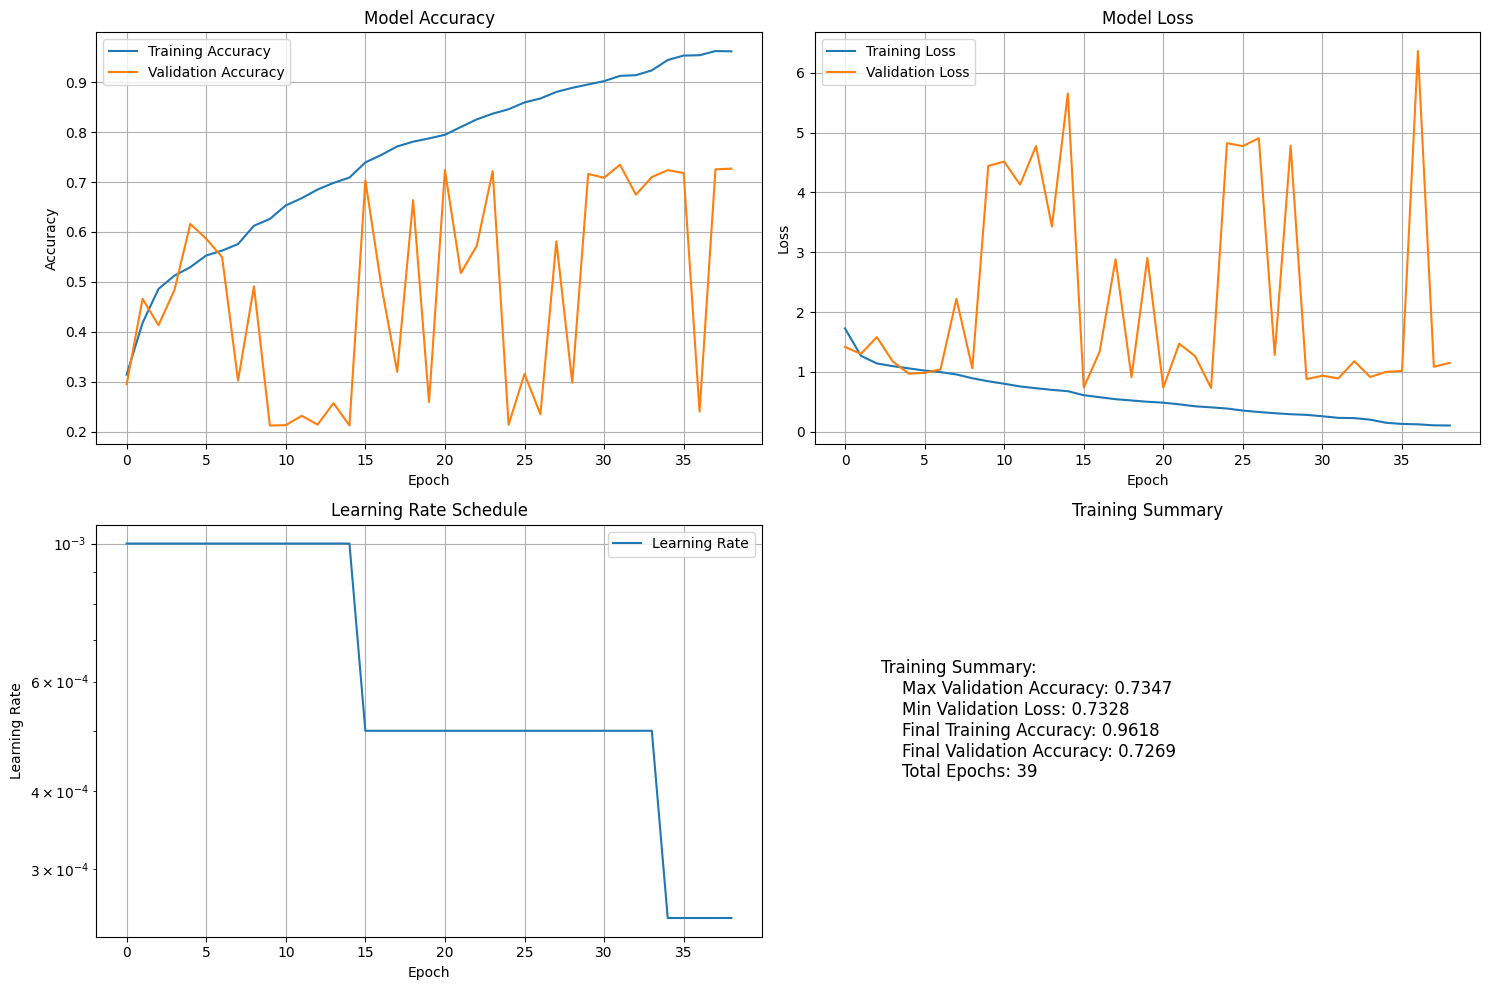

Making predictions on validation set...

📊 Model Performance:
Overall Accuracy: 0.7219

Per-Class Metrics:
  Bach:
    Precision: 0.8453
    Recall: 0.8909
    F1-Score: 0.8675
    Support: 834
  Beethoven:
    Precision: 0.5387
    Recall: 0.7039
    F1-Score: 0.6103
    Support: 662
  Chopin:
    Precision: 0.8710
    Recall: 0.7176
    F1-Score: 0.7869
    Support: 602
  Mozart:
    Precision: 0.6818
    Recall: 0.5503
    F1-Score: 0.6090
    Support: 736


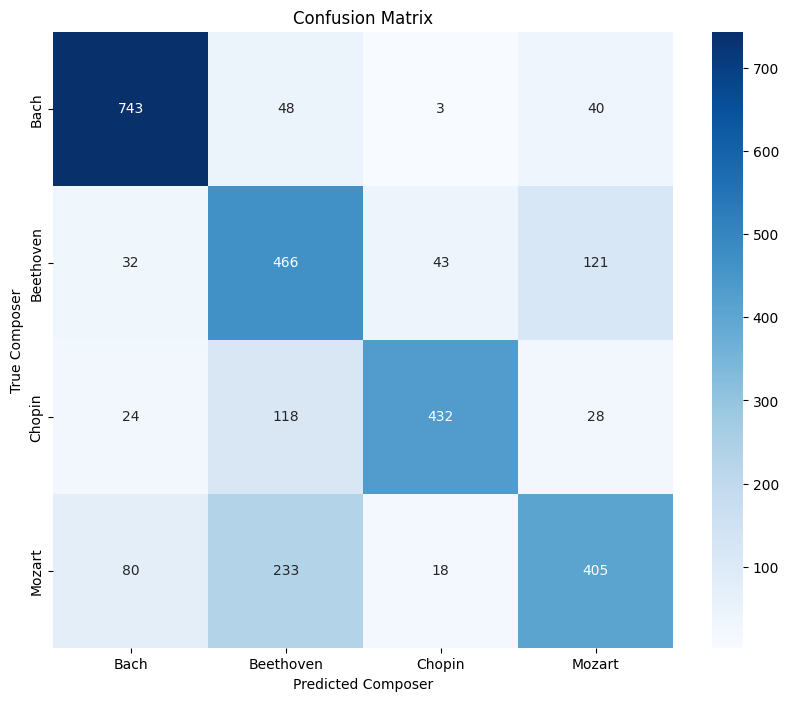


📋 Detailed Classification Report:
              precision    recall  f1-score   support

        Bach       0.85      0.89      0.87       834
   Beethoven       0.54      0.70      0.61       662
      Chopin       0.87      0.72      0.79       602
      Mozart       0.68      0.55      0.61       736

    accuracy                           0.72      2834
   macro avg       0.73      0.72      0.72      2834
weighted avg       0.74      0.72      0.72      2834


💾 Model saved as 'final_composer_classifier.keras'

🎼 Sample Predictions:
✅ True: Bach       | Predicted: Bach       | Confidence: 0.997
✅ True: Bach       | Predicted: Bach       | Confidence: 0.967
✅ True: Bach       | Predicted: Bach       | Confidence: 0.981
✅ True: Bach       | Predicted: Bach       | Confidence: 0.922
✅ True: Bach       | Predicted: Bach       | Confidence: 0.940
✅ True: Bach       | Predicted: Bach       | Confidence: 0.988
✅ True: Bach       | Predicted: Bach       | Confidence: 0.996
✅ True: Bach  

In [33]:
# Model Evaluation and Visualization

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def plot_training_history(history):
    """Plot training and validation metrics."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot training & validation accuracy
    axes[0, 0].plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Plot training & validation loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Plot learning rate (if available)
    if 'lr' in history.history:
        axes[1, 0].plot(history.history['lr'], label='Learning Rate')
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].legend()
        axes[1, 0].grid(True)
    
    # Summary statistics
    max_val_acc = max(history.history['val_sparse_categorical_accuracy'])
    min_val_loss = min(history.history['val_loss'])
    final_train_acc = history.history['sparse_categorical_accuracy'][-1]
    final_val_acc = history.history['val_sparse_categorical_accuracy'][-1]
    
    summary_text = f"""Training Summary:
    Max Validation Accuracy: {max_val_acc:.4f}
    Min Validation Loss: {min_val_loss:.4f}
    Final Training Accuracy: {final_train_acc:.4f}
    Final Validation Accuracy: {final_val_acc:.4f}
    Total Epochs: {len(history.history['loss'])}
    """
    
    axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, 
                    verticalalignment='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Training Summary')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_piano_val, X_pitch_val, y_val, composers):
    """Evaluate model performance and show detailed metrics."""
    
    # Make predictions
    print("Making predictions on validation set...")
    y_pred_proba = model.predict([X_piano_val, X_pitch_val], verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_val, y_pred, average=None)
    
    print(f"\n📊 Model Performance:")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nPer-Class Metrics:")
    for i, composer in enumerate(composers):
        print(f"  {composer}:")
        print(f"    Precision: {precision[i]:.4f}")
        print(f"    Recall: {recall[i]:.4f}")
        print(f"    F1-Score: {f1[i]:.4f}")
        print(f"    Support: {support[i]}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=composers, yticklabels=composers)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Composer')
    plt.ylabel('True Composer')
    plt.show()
    
    # Classification Report
    print("\n📋 Detailed Classification Report:")
    print(classification_report(y_val, y_pred, target_names=composers))
    
    return y_pred, y_pred_proba

# Plot training history
print("📈 Visualizing training history...")
plot_training_history(history)

# Evaluate the model
composers = ["Bach", "Beethoven", "Chopin", "Mozart"]
y_pred, y_pred_proba = evaluate_model(model, X_piano_val, X_pitch_val, y_val, composers)

# Save the final model
model.save('final_composer_classifier.keras')
print("\n💾 Model saved as 'final_composer_classifier.keras'")

# Display some prediction examples
print("\n🎼 Sample Predictions:")
for i in range(min(10, len(y_val))):
    true_composer = composers[y_val[i]]
    pred_composer = composers[y_pred[i]]
    confidence = y_pred_proba[i][y_pred[i]]
    status = "✅" if y_val[i] == y_pred[i] else "❌"
    print(f"{status} True: {true_composer:10} | Predicted: {pred_composer:10} | Confidence: {confidence:.3f}")
